# Group project - A neural Network model to compute implied volatility from option prices

In [2]:
import pandas as pd
from scipy.stats import qmc
from scipy.stats import norm
import numpy as np
from sklearn.utils import resample
import torch.nn as nn
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchmetrics import R2Score
from IPython.display import display, Markdown

## Create the dataset

We first create a sample dataset of model parameters by using moneynees S/K instead of
S and K separately. Thus, we create input features as
1. Moneyness: S/K with a narrow range: [0.5, 1.5] and a wide range: [0.4, 1.6]
2. Time to maturity: τ with a narrow range: [0.3, 0.95] and a wide range: [0.2, 1.1]
3. Risk free rate: r with a narrow range: [0.03, 0.08] and a wide range: [0.02, 0.1]
4. Volatility: σ with a narrow range: [0.02, 0.9] and a wide range: [0.01, 1.0]

In [3]:
def black_scholes_price(data):
    d1 = (np.log(data[:,0]) + (data[:,2] + (0.5*data[:,3]**2))*data[:,1]
          )/(data[:,3]*np.sqrt(data[:,1]))
    d2 = (np.log(data[:,0]) + (data[:,2] - (0.5*data[:,3]**2))*data[:,1]
          )/(data[:,3]*np.sqrt(data[:,1]))
    return data[:,0]*norm.cdf(d1) - np.exp(-1*data[:,1]*data[:,2]) \
        *norm.cdf(d2)

In [4]:
lhs = qmc.LatinHypercube(d=4, seed=1)
sample = lhs.random(n=10000)
n_l_bounds = [0.5, 0.3, 0.03, 0.02]
n_u_bounds = [1.5, 0.95, 0.08, 0.9]
w_l_bounds = [0.4, 0.2, 0.02, 0.01]
w_u_bounds = [1.6, 1.1, 0.1, 1.0]
narrow_data  = qmc.scale(sample, n_l_bounds, n_u_bounds)
narrow_data = np.column_stack((black_scholes_price(narrow_data),
                               narrow_data))
wide_data  = qmc.scale(sample, w_l_bounds, w_u_bounds)
wide_data = np.column_stack((black_scholes_price(wide_data),
                             wide_data))

## Pre-processing step

In [5]:
narrow_data[:,0] = narrow_data[:,0] - np.maximum(narrow_data[:,1] - np.exp(-1*narrow_data[:,3] * narrow_data[:,2]), 0)
narrow_data = narrow_data[narrow_data[:,0] >= 10e-7]
narrow_data[:, 0] = np.log(narrow_data[:, 0])
wide_data[:,0] = wide_data[:,0] - np.maximum(wide_data[:,1] - np.exp(-1*wide_data[:,3] * wide_data[:,2]), 0)
wide_data = wide_data[wide_data[:,0] >= 10e-7]
wide_data[:, 0] = np.log(wide_data[:, 0])

## Divide the data into training, validation and test sets

In [6]:
def split_and_scale_data(data, scale=1):
    data = resample(data, replace=True,
                    n_samples=int(data.shape[0]*scale),
                    random_state=1)
    X_train, X_temp, y_train, y_temp = train_test_split(
        data[:, [0,1,2,3]], data[:,4], test_size=0.2,
        random_state=1)
    X_valid, X_test, y_valid, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=1)

    X_train = torch.from_numpy(X_train).float().to('cuda')
    y_train = torch.from_numpy(y_train).float().to('cuda')
    X_valid = torch.from_numpy(X_valid).float().to('cuda')
    y_valid = torch.from_numpy(y_valid).float().to('cuda')
    X_test = torch.from_numpy(X_test).float().to('cuda')
    y_test = torch.from_numpy(y_test).float().to('cuda')
    del X_temp, y_temp
    return X_train, y_train, X_valid, y_valid, X_test, y_test

## Create a neural network

In [7]:
class ImpliedVolatilityModel:
    def __init__(self, X_train, y_train, X_valid, y_valid,
                 learning_rate):
        input_size = X_train.shape[1]
        hidden_sizes = [400, 400, 400 ,400]
        all_layers = []
        output_size = 1
        self.batch_size = 1024
        train_ds = TensorDataset(X_train, y_train)
        valid_ds = TensorDataset(X_valid, y_valid)
        torch.manual_seed(1)
        self.train_dl = DataLoader(train_ds, self.batch_size,
                                   shuffle=True)
        self.valid_dl = DataLoader(valid_ds, self.batch_size,
                                   shuffle=True)
        for hidden_size in hidden_sizes:
            all_layers.append(nn.Linear(input_size, hidden_size))
            all_layers.append(nn.ReLU())
            input_size = hidden_size
        all_layers.append(nn.Linear(input_size, output_size))
        self.model = nn.Sequential(*all_layers).to('cuda')
        nn.init.xavier_uniform_(self.model[0].weight)
        self.loss_fn = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(),
                                          lr=learning_rate)

## Perform model training

In [8]:
class ImpliedVolatilityModel(ImpliedVolatilityModel):
    def train(self, num_epochs=50):
        loss_hist = [0] * num_epochs # list of size num_epochs
        valid_loss_hist = [0] * num_epochs

        for epoch in range(num_epochs):
            for x_batch, y_batch in self.train_dl:
                pred = self.model(x_batch)
                y_batch = y_batch.unsqueeze(1)
                loss = self.loss_fn(pred, y_batch)
                loss.backward() # computes the gradient using backpropagation
                self.optimizer.step() # performs the parameter update
                self.optimizer.zero_grad() # make the derivatives zero again for the next iteration
                loss_hist[epoch] += loss.item() * self.batch_size
            with torch.no_grad():
                for x_batch, y_batch in self.valid_dl:
                    pred = self.model(x_batch)
                    y_batch = y_batch.unsqueeze(1)
                    loss = self.loss_fn(pred, y_batch)
                    valid_loss_hist[epoch] += loss.item() * \
                                              self.batch_size
            loss_hist[epoch] /= len(self.train_dl.dataset)
            valid_loss_hist[epoch] /= len(self.valid_dl.dataset)
            print(f'Epoch: {epoch+1:03d}/{num_epochs:03d} '
                  f'| Train MSE: {loss_hist[epoch]} '
                  f'| Valid MSE: {valid_loss_hist[epoch]}')
        return loss_hist, valid_loss_hist

## MSE over training and validation sets

In [9]:
class ImpliedVolatilityModel(ImpliedVolatilityModel):
    def plot_train_valid_mse(self, train_loss, valid_loss):
        plt.plot(range(len(train_loss)), train_loss,
                 label='Training')
        plt.plot(range(len(valid_loss)), valid_loss,
                 label='Validation')
        plt.ylabel('MSELoss')
        plt.xlabel('Epochs')
        plt.yscale('log')
        plt.title('Epochs Vs MSELoss')

        plt.legend(loc='upper right')
        plt.show()

## Model testing

In [10]:
class ImpliedVolatilityModel(ImpliedVolatilityModel):
    def test(self, X_test, y_test):
        r2_cal = R2Score()
        with torch.no_grad():
            pred = self.model(X_test).squeeze(1).cpu()
            y_test = y_test.cpu()
            loss = self.loss_fn(pred, y_test)
            mse_loss = loss.item()
            r2 = (r2_cal(pred, y_test).detach().item())
        print(f"R2 Score in Test data: {r2}")
        print(f"MSELoss in Test data: {mse_loss}")

        plt.scatter(y_test, pred, color='blue', marker='o',
                    s=50, label='Predicted', alpha=1)
        plt.scatter(y_test, y_test, color='red', marker='s',
                    label='True', alpha=0.01)
        plt.xlabel('True Values')
        plt.ylabel('Predicted Values')
        plt.title('Scatter Plot of True and Predicted Values')
        plt.legend()
        plt.show()

In [11]:
scales = [0.25, 0.5, 1, 2, 4]

### Narrow Dataset(0.25 times original data) with Learning rate: 0.001

Epoch: 001/300 | Train MSE: 0.327251732867697 | Valid MSE: 0.6117323502250339
Epoch: 002/300 | Train MSE: 0.13318984404854153 | Valid MSE: 0.5665957906971807
Epoch: 003/300 | Train MSE: 0.12251345178355341 | Valid MSE: 0.2755664991295856
Epoch: 004/300 | Train MSE: 0.07227288536403491 | Valid MSE: 0.2626429350479789
Epoch: 005/300 | Train MSE: 0.05890089739923892 | Valid MSE: 0.12551555633544922
Epoch: 006/300 | Train MSE: 0.03865744341974673 | Valid MSE: 0.14913197393002717
Epoch: 007/300 | Train MSE: 0.03360249166903288 | Valid MSE: 0.11731993633767833
Epoch: 008/300 | Train MSE: 0.03349987631258757 | Valid MSE: 0.12519458273182746
Epoch: 009/300 | Train MSE: 0.029443940909012506 | Valid MSE: 0.12048292574675187
Epoch: 010/300 | Train MSE: 0.030512053033579952 | Valid MSE: 0.10789291547692341
Epoch: 011/300 | Train MSE: 0.02539027151854142 | Valid MSE: 0.09986001719599184
Epoch: 012/300 | Train MSE: 0.02515441956727401 | Valid MSE: 0.09819959557574728
Epoch: 013/300 | Train MSE: 0.02

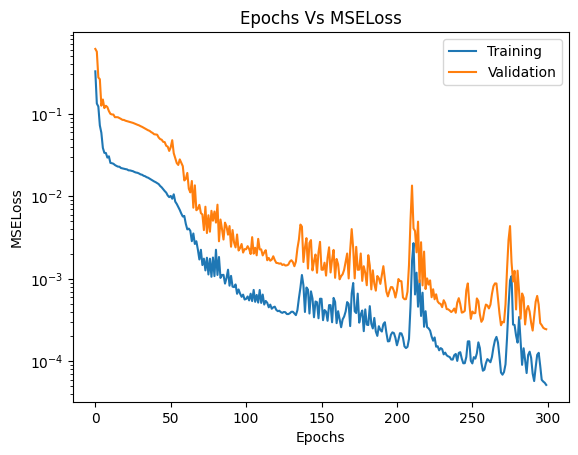

R2 Score in Test data: 0.998859167098999
MSELoss in Test data: 6.808141915826127e-05


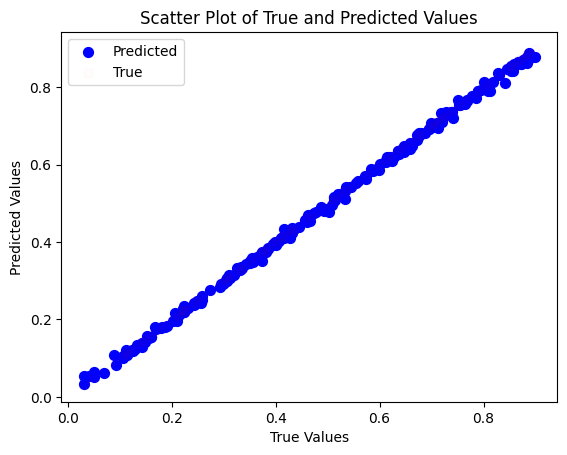

### Narrow Dataset(0.5 times original data) with Learning rate: 0.001

Epoch: 001/300 | Train MSE: 0.22966659201839895 | Valid MSE: 0.2505247033160666
Epoch: 002/300 | Train MSE: 0.09347983839329868 | Valid MSE: 0.13966072745945143
Epoch: 003/300 | Train MSE: 0.04801546079702463 | Valid MSE: 0.07475525399912959
Epoch: 004/300 | Train MSE: 0.033484832776107726 | Valid MSE: 0.06519200698189113
Epoch: 005/300 | Train MSE: 0.030374347694021826 | Valid MSE: 0.05286386738652769
Epoch: 006/300 | Train MSE: 0.025865496775599416 | Valid MSE: 0.0475231004797894
Epoch: 007/300 | Train MSE: 0.024613782783721783 | Valid MSE: 0.045270136128301205
Epoch: 008/300 | Train MSE: 0.02324650553833107 | Valid MSE: 0.04510567706564198
Epoch: 009/300 | Train MSE: 0.022452941247867002 | Valid MSE: 0.04410164459891941
Epoch: 010/300 | Train MSE: 0.021642445546393482 | Valid MSE: 0.04234270842179008
Epoch: 011/300 | Train MSE: 0.021656045703841303 | Valid MSE: 0.042670975560727326
Epoch: 012/300 | Train MSE: 0.021283789388319294 | Valid MSE: 0.040246138365372365
Epoch: 013/300 | Tr

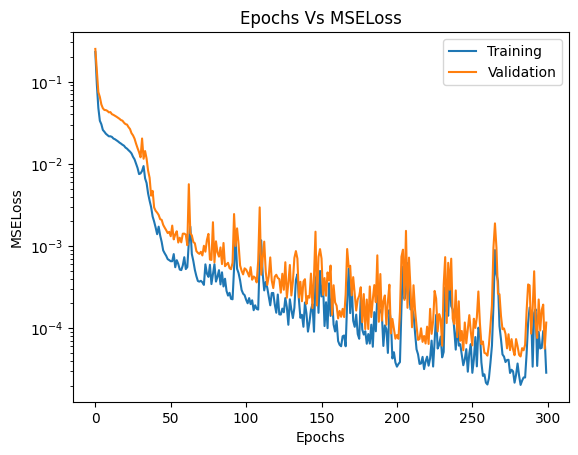

R2 Score in Test data: 0.9990265965461731
MSELoss in Test data: 5.488596434588544e-05


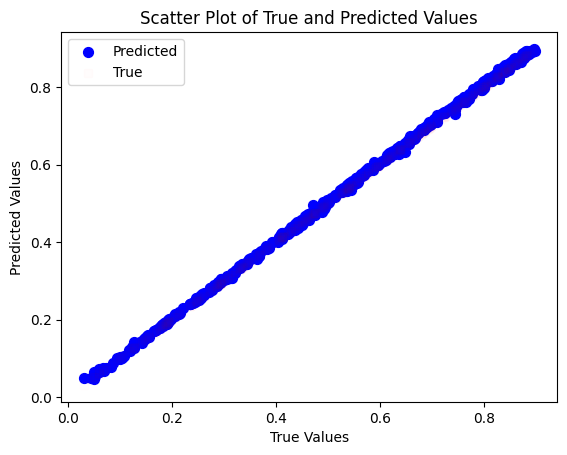

### Narrow Dataset(1 times original data) with Learning rate: 0.001

Epoch: 001/300 | Train MSE: 0.1628240833751342 | Valid MSE: 0.07080019245976987
Epoch: 002/300 | Train MSE: 0.04051300638414637 | Valid MSE: 0.03290077914362368
Epoch: 003/300 | Train MSE: 0.02785577117368674 | Valid MSE: 0.02496620053830354
Epoch: 004/300 | Train MSE: 0.024354578246407157 | Valid MSE: 0.02398896424666695
Epoch: 005/300 | Train MSE: 0.0229548387321525 | Valid MSE: 0.02282277190166971
Epoch: 006/300 | Train MSE: 0.022135139661170082 | Valid MSE: 0.02198221787162449
Epoch: 007/300 | Train MSE: 0.02024132742694615 | Valid MSE: 0.020318686443826426
Epoch: 008/300 | Train MSE: 0.0195425700092225 | Valid MSE: 0.019420868417491084
Epoch: 009/300 | Train MSE: 0.01832835389012538 | Valid MSE: 0.018613450423530912
Epoch: 010/300 | Train MSE: 0.017825171721786257 | Valid MSE: 0.017334873779960302
Epoch: 011/300 | Train MSE: 0.016759273783434964 | Valid MSE: 0.016007855664128844
Epoch: 012/300 | Train MSE: 0.015417134488193979 | Valid MSE: 0.014827932482180388
Epoch: 013/300 | Tra

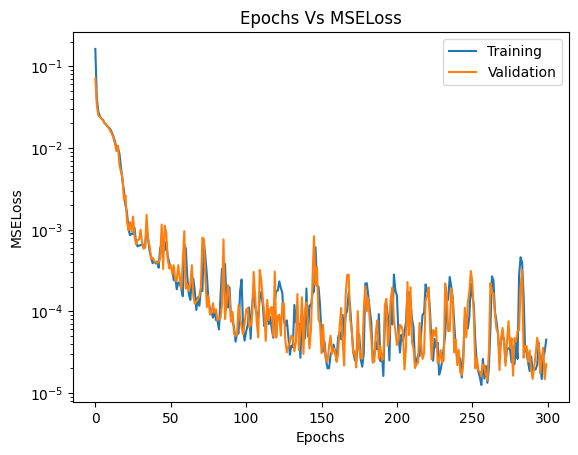

R2 Score in Test data: 0.9996533989906311
MSELoss in Test data: 1.9214823623769917e-05


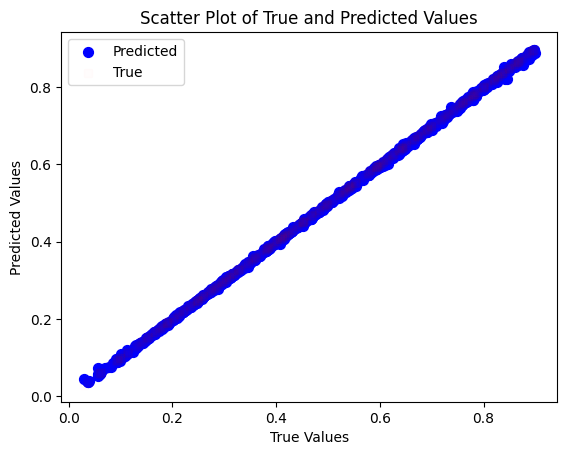

### Narrow Dataset(2 times original data) with Learning rate: 0.001

Epoch: 001/300 | Train MSE: 0.1010655764893606 | Valid MSE: 0.03664893627425758
Epoch: 002/300 | Train MSE: 0.024838322063478684 | Valid MSE: 0.025138767953154704
Epoch: 003/300 | Train MSE: 0.021109233096163024 | Valid MSE: 0.022148537415644837
Epoch: 004/300 | Train MSE: 0.018982277476041195 | Valid MSE: 0.019954327070991477
Epoch: 005/300 | Train MSE: 0.0168739381277511 | Valid MSE: 0.01739237763064507
Epoch: 006/300 | Train MSE: 0.014572100035120704 | Valid MSE: 0.014436150944019257
Epoch: 007/300 | Train MSE: 0.01167047067487044 | Valid MSE: 0.01263577597481864
Epoch: 008/300 | Train MSE: 0.009128431384692645 | Valid MSE: 0.0071556636783365705
Epoch: 009/300 | Train MSE: 0.004906032115532687 | Valid MSE: 0.005460651590408416
Epoch: 010/300 | Train MSE: 0.0033863056585158274 | Valid MSE: 0.003168455483407057
Epoch: 011/300 | Train MSE: 0.001742975374740151 | Valid MSE: 0.0011277291387530011
Epoch: 012/300 | Train MSE: 0.0009378374804787284 | Valid MSE: 0.0007690588525298624
Epoch: 

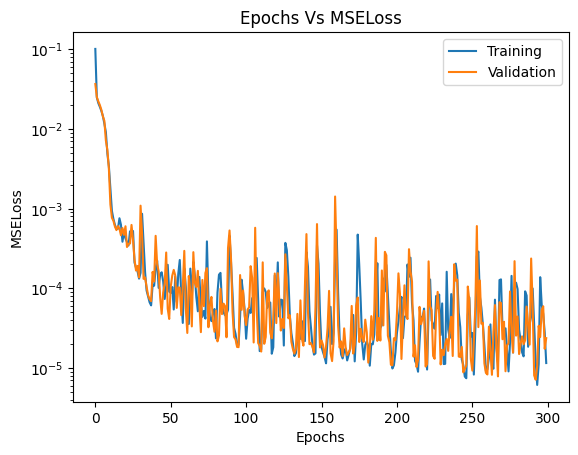

R2 Score in Test data: 0.9996465444564819
MSELoss in Test data: 2.034748649748508e-05


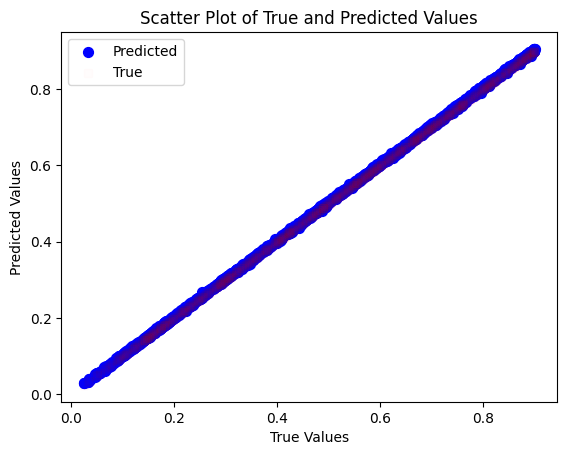

### Narrow Dataset(4 times original data) with Learning rate: 0.001

Epoch: 001/300 | Train MSE: 0.06472388943236078 | Valid MSE: 0.025276529601188796
Epoch: 002/300 | Train MSE: 0.02019449169506574 | Valid MSE: 0.02113425012906565
Epoch: 003/300 | Train MSE: 0.016721966149090394 | Valid MSE: 0.01627857098431771
Epoch: 004/300 | Train MSE: 0.011758133362253674 | Valid MSE: 0.008818804602594495
Epoch: 005/300 | Train MSE: 0.004716858018858025 | Valid MSE: 0.002607776379209702
Epoch: 006/300 | Train MSE: 0.00440775132626113 | Valid MSE: 0.0014229852955086214
Epoch: 007/300 | Train MSE: 0.0008456588649529568 | Valid MSE: 0.0006581709994886441
Epoch: 008/300 | Train MSE: 0.000490782715397394 | Valid MSE: 0.000458581924503229
Epoch: 009/300 | Train MSE: 0.0003904121262975706 | Valid MSE: 0.0003988601425171934
Epoch: 010/300 | Train MSE: 0.00033094778982789623 | Valid MSE: 0.00030850407418059886
Epoch: 011/300 | Train MSE: 0.0002687295647592271 | Valid MSE: 0.00026610856273781667
Epoch: 012/300 | Train MSE: 0.0002164587795402504 | Valid MSE: 0.000295532067012

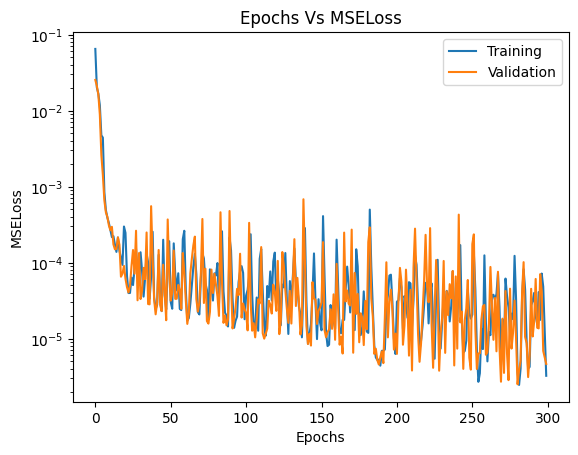

R2 Score in Test data: 0.9999268054962158
MSELoss in Test data: 4.12119879911188e-06


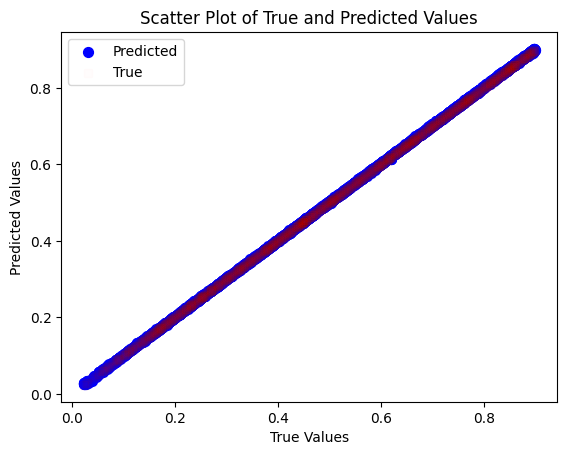

In [12]:
for scale in scales:
    display(Markdown(f"### Narrow Dataset({scale} times original data) "
                     f"with Learning rate: 0.001"))
    X_train, y_train, X_valid, y_valid, X_test, y_test = \
        split_and_scale_data(narrow_data, scale)
    n_bs = ImpliedVolatilityModel(X_train, y_train, X_valid,
                             y_valid, 0.001)
    train_loss, valid_loss = n_bs.train(num_epochs=300)
    n_bs.plot_train_valid_mse(train_loss, valid_loss)
    n_bs.test(X_test, y_test)

### Wide Dataset(0.25 times original data) with Learning rate: 0.001

Epoch: 001/300 | Train MSE: 0.41676598740897003 | Valid MSE: 0.863902113172743
Epoch: 002/300 | Train MSE: 0.1796724364012314 | Valid MSE: 0.6262251790364584
Epoch: 003/300 | Train MSE: 0.15944080968056956 | Valid MSE: 0.3690364922417535
Epoch: 004/300 | Train MSE: 0.09416477513127651 | Valid MSE: 0.37250369601779515
Epoch: 005/300 | Train MSE: 0.08098839917888366 | Valid MSE: 0.20886913723415798
Epoch: 006/300 | Train MSE: 0.05273224275820247 | Valid MSE: 0.23198450724283853
Epoch: 007/300 | Train MSE: 0.05297181126273116 | Valid MSE: 0.18048707750108506
Epoch: 008/300 | Train MSE: 0.047487224964994745 | Valid MSE: 0.21674333360460069
Epoch: 009/300 | Train MSE: 0.04872610624693127 | Valid MSE: 0.17728658040364584
Epoch: 010/300 | Train MSE: 0.04618091180141563 | Valid MSE: 0.17640767415364583
Epoch: 011/300 | Train MSE: 0.0421861684627342 | Valid MSE: 0.16257866753472222
Epoch: 012/300 | Train MSE: 0.03982134894348756 | Valid MSE: 0.16343751695421008
Epoch: 013/300 | Train MSE: 0.039

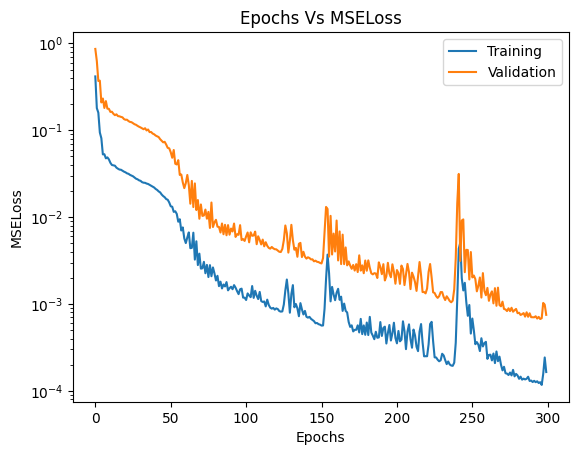

R2 Score in Test data: 0.9983057975769043
MSELoss in Test data: 0.0001131369499489665


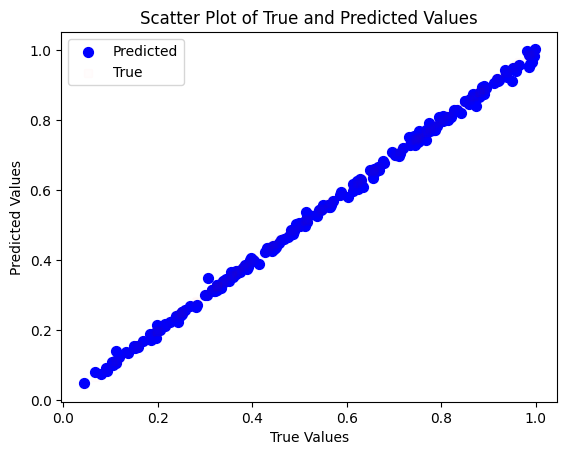

### Wide Dataset(0.5 times original data) with Learning rate: 0.001

Epoch: 001/300 | Train MSE: 0.3014098645847817 | Valid MSE: 0.3643114556206597
Epoch: 002/300 | Train MSE: 0.14405094184917921 | Valid MSE: 0.2026087612575955
Epoch: 003/300 | Train MSE: 0.07767713799227331 | Valid MSE: 0.11884448581271702
Epoch: 004/300 | Train MSE: 0.053679473673276294 | Valid MSE: 0.09007170783148871
Epoch: 005/300 | Train MSE: 0.04676008277528145 | Valid MSE: 0.08288641187879775
Epoch: 006/300 | Train MSE: 0.043114434094795 | Valid MSE: 0.07453788757324219
Epoch: 007/300 | Train MSE: 0.03966036999185836 | Valid MSE: 0.07286307440863715
Epoch: 008/300 | Train MSE: 0.037449769899497706 | Valid MSE: 0.06914293077256944
Epoch: 009/300 | Train MSE: 0.03502734961843862 | Valid MSE: 0.06719390445285374
Epoch: 010/300 | Train MSE: 0.03429970088869631 | Valid MSE: 0.06441706763373481
Epoch: 011/300 | Train MSE: 0.03285411785919223 | Valid MSE: 0.06274688296847873
Epoch: 012/300 | Train MSE: 0.031121197743993977 | Valid MSE: 0.059606742858886716
Epoch: 013/300 | Train MSE: 0

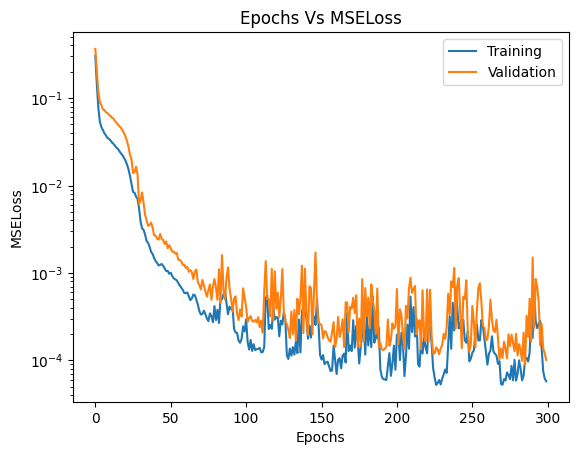

R2 Score in Test data: 0.9993831515312195
MSELoss in Test data: 4.321393498685211e-05


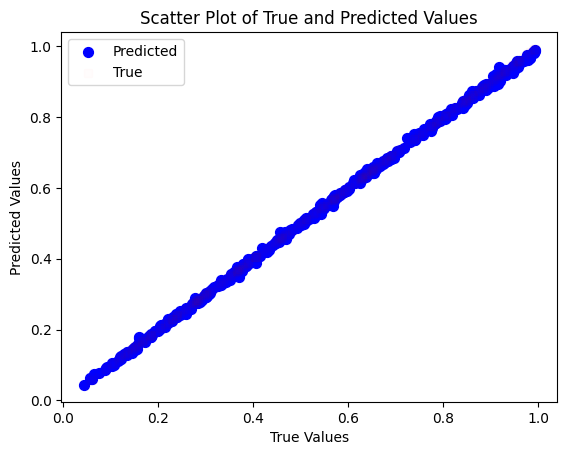

### Wide Dataset(1 times original data) with Learning rate: 0.001

Epoch: 001/300 | Train MSE: 0.22075262910165752 | Valid MSE: 0.12148915461624027
Epoch: 002/300 | Train MSE: 0.06953965951443912 | Valid MSE: 0.045108188378797626
Epoch: 003/300 | Train MSE: 0.047260306164527026 | Valid MSE: 0.04085634123364068
Epoch: 004/300 | Train MSE: 0.03680961344816766 | Valid MSE: 0.038337817844479975
Epoch: 005/300 | Train MSE: 0.0357641825120516 | Valid MSE: 0.03447595029837298
Epoch: 006/300 | Train MSE: 0.03140024519775323 | Valid MSE: 0.03185492654530968
Epoch: 007/300 | Train MSE: 0.02968341985410341 | Valid MSE: 0.029574403773425552
Epoch: 008/300 | Train MSE: 0.02783908663705418 | Valid MSE: 0.027402060978669877
Epoch: 009/300 | Train MSE: 0.027532628684829995 | Valid MSE: 0.02503369408799491
Epoch: 010/300 | Train MSE: 0.02390520420875157 | Valid MSE: 0.023372109129908884
Epoch: 011/300 | Train MSE: 0.021247996599898924 | Valid MSE: 0.023733730973868536
Epoch: 012/300 | Train MSE: 0.019960267563014684 | Valid MSE: 0.020553232432737763
Epoch: 013/300 | T

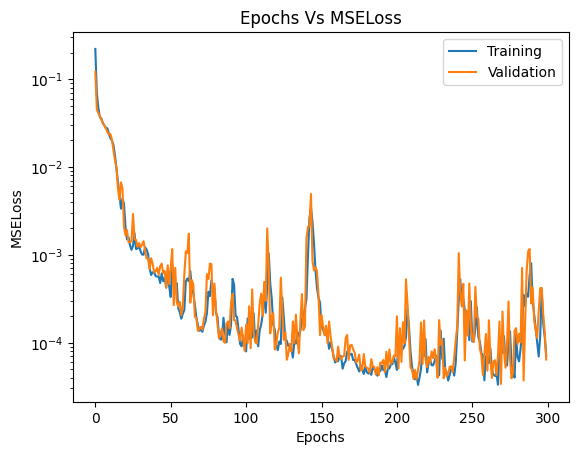

R2 Score in Test data: 0.9991812705993652
MSELoss in Test data: 5.6041255447780713e-05


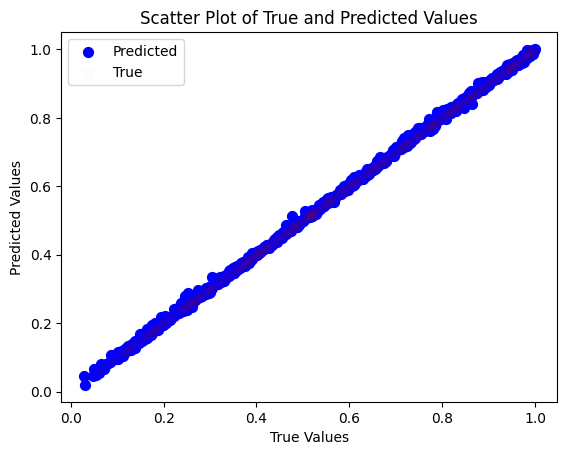

### Wide Dataset(2 times original data) with Learning rate: 0.001

Epoch: 001/300 | Train MSE: 0.13388421650160873 | Valid MSE: 0.052874562473943856
Epoch: 002/300 | Train MSE: 0.04108145000340046 | Valid MSE: 0.03736849239364209
Epoch: 003/300 | Train MSE: 0.03221891269042222 | Valid MSE: 0.033509251804998544
Epoch: 004/300 | Train MSE: 0.027564445667410016 | Valid MSE: 0.02850489380493503
Epoch: 005/300 | Train MSE: 0.02386641734369536 | Valid MSE: 0.02500165310616358
Epoch: 006/300 | Train MSE: 0.02096617324570334 | Valid MSE: 0.021571885088273325
Epoch: 007/300 | Train MSE: 0.01757027601115333 | Valid MSE: 0.01588101039799536
Epoch: 008/300 | Train MSE: 0.01183950765152126 | Valid MSE: 0.009031186838028098
Epoch: 009/300 | Train MSE: 0.007861100702707324 | Valid MSE: 0.004892120499157653
Epoch: 010/300 | Train MSE: 0.0038863725220789204 | Valid MSE: 0.007062451848724009
Epoch: 011/300 | Train MSE: 0.003233104355970886 | Valid MSE: 0.0024310372285275676
Epoch: 012/300 | Train MSE: 0.0019426421718793609 | Valid MSE: 0.0016236549751701588
Epoch: 013/

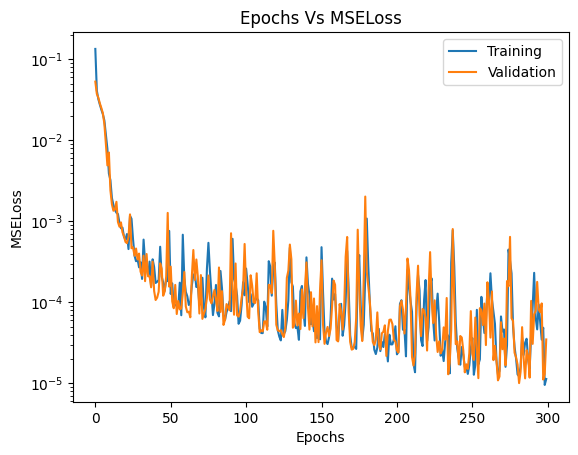

R2 Score in Test data: 0.9995695352554321
MSELoss in Test data: 2.922864405263681e-05


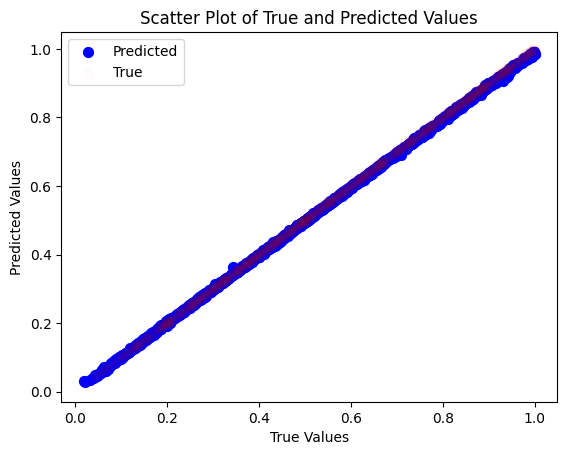

### Wide Dataset(4 times original data) with Learning rate: 0.001

Epoch: 001/300 | Train MSE: 0.08424624441629172 | Valid MSE: 0.03816823081768716
Epoch: 002/300 | Train MSE: 0.02844920491279114 | Valid MSE: 0.028641870693262995
Epoch: 003/300 | Train MSE: 0.02095343580536611 | Valid MSE: 0.019267267010296123
Epoch: 004/300 | Train MSE: 0.010875962485356399 | Valid MSE: 0.006447921967155111
Epoch: 005/300 | Train MSE: 0.0030367271892803318 | Valid MSE: 0.0018303638569076492
Epoch: 006/300 | Train MSE: 0.0014332335698752472 | Valid MSE: 0.0014113732964454971
Epoch: 007/300 | Train MSE: 0.0011359274327293084 | Valid MSE: 0.0017907979722350446
Epoch: 008/300 | Train MSE: 0.0010330029701629002 | Valid MSE: 0.0008217152171841522
Epoch: 009/300 | Train MSE: 0.0007310496177087422 | Valid MSE: 0.000964943985492281
Epoch: 010/300 | Train MSE: 0.0007184276801772548 | Valid MSE: 0.0005545654096701492
Epoch: 011/300 | Train MSE: 0.0004923352792703215 | Valid MSE: 0.00039851959625946206
Epoch: 012/300 | Train MSE: 0.0006546031489632238 | Valid MSE: 0.000338191252

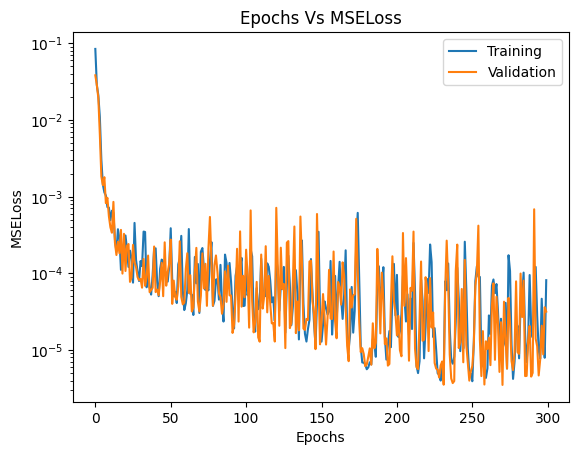

R2 Score in Test data: 0.9996135234832764
MSELoss in Test data: 2.6989413527189754e-05


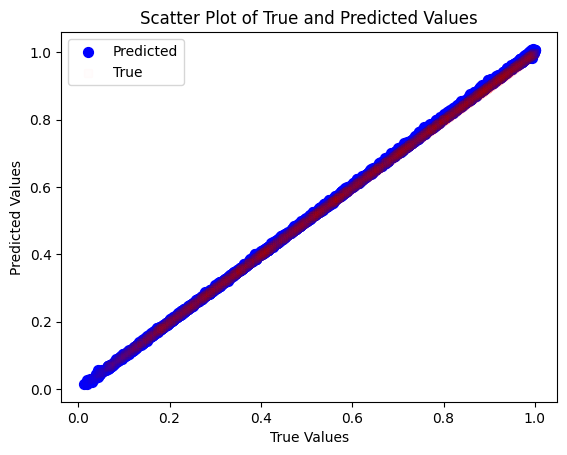

In [13]:
for scale in scales:
    display(Markdown(f"### Wide Dataset({scale} times original data) "
                     f"with Learning rate: 0.001"))
    X_train, y_train, X_valid, y_valid, X_test, y_test = \
        split_and_scale_data(wide_data, scale)
    n_bs = ImpliedVolatilityModel(X_train, y_train, X_valid,
                                  y_valid, 0.001)
    train_loss, valid_loss = n_bs.train(num_epochs=300)
    n_bs.plot_train_valid_mse(train_loss, valid_loss)
    n_bs.test(X_test, y_test)